## prepare_eicu_alone

In [2]:
#configure for local eicu databse
exec(open("/Users/grovesdixon/gitreps/Insight_fellowship_project/merge/configure_eicu.py").read())

Database: eicu
Username: postgres

Configured for local EICU database.


In [3]:
#load patient data
#load patients data eicu
query = query_schema + """
select 
    patientunitstayid,
    patienthealthsystemstayid,
    gender,
    age,
    ethnicity,
    hospitalid,
    admissionweight
from patient
"""

ep_dat = pd.read_sql_query(query, con)
print(query)
ep_dat.head()

set search_path to public,eicu_crd;
select 
    patientunitstayid,
    patienthealthsystemstayid,
    gender,
    age,
    ethnicity,
    hospitalid,
    admissionweight
from patient



,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,admissionweight
0,141168,128919,Female,70,Caucasian,59,84.3
1,141178,128927,Female,52,Caucasian,60,54.4
2,141179,128927,Female,52,Caucasian,60,NaN
3,141194,128941,Male,68,Caucasian,73,73.9
4,141196,128943,Male,71,Caucasian,67,NaN


In [4]:
#load hospital data eicu
query = query_schema + """
select 
    hospitalid,
    numbedscategory,
    region
from hospital
"""

eh_dat = pd.read_sql_query(query, con)
print(query)
eh_dat.head()

set search_path to public,eicu_crd;
select 
    hospitalid,
    numbedscategory,
    region
from hospital



,hospitalid,numbedscategory,region
0,56,<100,Midwest
1,58,100 - 249,Midwest
2,59,<100,Midwest
3,60,<100,Midwest
4,61,<100,Midwest


In [5]:
#build the patient dataframe
pdat = pd.merge(ep_dat, eh_dat, how='inner', on = ['hospitalid']) #pateints and hospitals
pdat.loc[pdat['gender']=='', 'gender'] = 'Unknown'
pdat.loc[pdat['gender']=='Other', 'gender'] = 'Unknown'
pdat.loc[pdat['admissionweight'].isna(), 'admissionweight'] = np.mean(pdat['admissionweight'])
pdat.loc[pdat['age']=='> 89', 'age'] = 91
pdat['age'] = pd.to_numeric(pdat['age'])
pdat['hospitalid'] = 'hospital_' + pdat['hospitalid'].astype('str')
pdat = pdat.loc[pdat['age'].notna(), ] #just remove those with missing age
pdat.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,admissionweight,numbedscategory,region
0,141168,128919,Female,70.0,Caucasian,hospital_59,84.30000,<100,Midwest
1,141263,128998,Male,19.0,Caucasian,hospital_59,83.93392,<100,Midwest
2,141264,128998,Male,19.0,Caucasian,hospital_59,83.93392,<100,Midwest
3,141304,129031,Male,70.0,Caucasian,hospital_59,83.93392,<100,Midwest
4,141432,129140,Male,75.0,Caucasian,hospital_59,131.50000,<100,Midwest


In [6]:
#load medications
query = query_schema + """
SELECT 
    drugname,
    patientunitstayid,
    drugordercancelled
from medication
WHERE
    drugordercancelled = 'No'
"""
print('patients query:')
print(query)
em_dat = pd.read_sql_query(query,con)
em_dat = em_dat.drop(['drugordercancelled'], 1)
print(len(em_dat['drugname'].unique()))
em_dat.head()

patients query:
set search_path to public,eicu_crd;
SELECT 
    drugname,
    patientunitstayid,
    drugordercancelled
from medication
WHERE
    drugordercancelled = 'No'

1412


,drugname,patientunitstayid
0,METOPROLOL TARTRATE 25 MG PO TABS,141168
1,3 ML - IPRATROPIUM-ALBUTEROL 0.5-2.5 (3) MG/...,141168
2,ASPIRIN EC 81 MG PO TBEC,141168
3,3 ML - IPRATROPIUM-ALBUTEROL 0.5-2.5 (3) MG/...,141168
4,ENOXAPARIN SODIUM 40 MG/0.4ML SC SOLN,141168


In [7]:
#function to build boolean column for a column of hospital events
def build_presence_absence_cols(stay_ids, long_df, long_col):
    df = pd.DataFrame(stay_ids)
    levels = long_df[long_col].unique()
    print('making columns for {} levels'.format(len(levels)))
    counter = 0
    for l in levels:
        counter += 1
        if counter % 100 == 0:
            print('level {} of {}'.format(counter, len(levels)))
        new_col = '{}_{}'.format(long_col, l)
        l_ids = long_df.loc[long_df[long_col]==l, 'patientunitstayid']
        df[new_col] = df['patientunitstayid'].isin(l_ids).astype(int)
    return df

In [9]:
#build boolean columns for diagnoses and add to pdat
stay_ids = pdat['patientunitstayid']
em_cols = build_presence_absence_cols(stay_ids, em_dat, 'drugname')
print(em_cols.shape)
em_cols.head()

making columns for 1412 levels
level 100 of 1412
level 200 of 1412
level 300 of 1412
level 400 of 1412
level 500 of 1412
level 600 of 1412
level 700 of 1412
level 800 of 1412
level 900 of 1412
level 1000 of 1412
level 1100 of 1412
level 1200 of 1412
level 1300 of 1412
level 1400 of 1412
(200764, 1413)


,patientunitstayid,drugname_METOPROLOL TARTRATE 25 MG PO TABS,drugname_3 ML - IPRATROPIUM-ALBUTEROL 0.5-2.5 (3) MG/3ML IN SOLN,drugname_ASPIRIN EC 81 MG PO TBEC,drugname_ENOXAPARIN SODIUM 40 MG/0.4ML SC SOLN,drugname_HYDROCORTISONE NA SUCCINATE PF 100 MG IJ SOLR,drugname_3.5 G - REFRESH P.M. OP OINT,drugname_3 ML VIAL : INSULIN LISPRO (HUMAN) 100 UNIT/ML SC SOLN,drugname_SENNOSIDES-DOCUSATE SODIUM 8.6-50 MG PO TABS,drugname_100 ML - MAGNESIUM SULFATE IN D5W 10-5 MG/ML-% IV SOLN,...,drugname_amiodarone bolus,drugname_Dextrose 50% in Water,drugname_500 ML : HEPARIN (PORCINE) IN D5W 50-5 UNIT/ML-% IV SOLN,drugname_NACL 0.9% (1566),drugname_Sodium Chloride 0.9% FLUSH,drugname_Heparin (Porcine) in 1/2 NS,drugname_sodium cl 0.9% FLUSH 1ea/10ml,drugname_MAGNESIUM SULFATE 50 % (4 MEQ/ML) INJ,drugname_Calcium Gluconate 10% SSO,drugname_SODIUM CHLORIDE BACTERIOSTATIC 0.9 % INJ SOLN
0,141168,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,141263,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,141264,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,141304,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,141432,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# load diagnosis from eicu
query = query_schema + """
SELECT 
    patientunitstayid,
    diagnosisstring,
    icd9code
from diagnosis
"""
print('patients query:')
print(query)
ed_dat = pd.read_sql_query(query,con)
ed_dat[['icd9Code','extra']] = ed_dat['icd9code'].str.split(pat=',', expand=True, n=1)
ed_dat = ed_dat.drop(['icd9code', 'extra'], 1)
ed_dat.loc[ed_dat['diagnosisstring'].str.contains('diffici'), 'icd9Code'] = '008.45' #replace some missing codes
ed_dat.head()

patients query:
set search_path to public,eicu_crd;
SELECT 
    patientunitstayid,
    diagnosisstring,
    icd9code
from diagnosis



,patientunitstayid,diagnosisstring,icd9Code
0,141168,cardiovascular|chest pain / ASHD|coronary arte...,414.00
1,141168,cardiovascular|ventricular disorders|cardiomyo...,
2,141168,pulmonary|disorders of the airways|COPD,491.20
3,141168,pulmonary|disorders of the airways|COPD,491.20
4,141168,cardiovascular|ventricular disorders|congestiv...,428.0


In [11]:
np.sum(ed_dat['icd9Code']=='008.45')

6931

In [12]:
#build boolean columns for diagnoses and add to pdat
stay_ids = pdat['patientunitstayid']
ed_cols = build_presence_absence_cols(stay_ids, ed_dat, 'icd9Code')
print(ed_cols.shape)
ed_cols.head()

making columns for 920 levels
level 100 of 920
level 200 of 920
level 300 of 920
level 400 of 920
level 500 of 920
level 600 of 920
level 700 of 920
level 800 of 920
level 900 of 920
(200764, 921)


,patientunitstayid,icd9Code_414.00,icd9Code_,icd9Code_491.20,icd9Code_428.0,icd9Code_427.31,icd9Code_585.9,icd9Code_518.82,icd9Code_294.9,icd9Code_345.90,...,icd9Code_801.50,icd9Code_130.0,icd9Code_483.1,icd9Code_G95.9,icd9Code_041.09,icd9Code_810.10,icd9Code_835.10,icd9Code_041.19,icd9Code_811.10,icd9Code_320.3
0,141168,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,141263,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,141264,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,141304,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,141432,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## combine results

In [13]:
#onehot encode the pdat columns
to_onehot = [
    'gender',
    'ethnicity',
    'hospitalid',
    'numbedscategory',
    'region'
]
ep_cols = pd.get_dummies(pdat, columns = to_onehot, drop_first = True)
ep_cols.head()

,patientunitstayid,patienthealthsystemstayid,age,admissionweight,gender_Male,gender_Unknown,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,...,hospitalid_hospital_93,hospitalid_hospital_94,hospitalid_hospital_95,hospitalid_hospital_96,numbedscategory_250 - 499,numbedscategory_<100,numbedscategory_>= 500,region_Northeast,region_South,region_West
0,141168,128919,70.0,84.30000,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,141263,128998,19.0,83.93392,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,141264,128998,19.0,83.93392,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,141304,129031,70.0,83.93392,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,141432,129140,75.0,131.50000,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [22]:
#pdat
#em_cols
#ed_cols
cat_list = [
    ep_cols,
    em_cols.drop('patientunitstayid', 1),
    ed_cols.drop('patientunitstayid', 1)]
cdat = pd.concat(cat_list, axis=1)
print(cdat.shape)
cdat.head()
cdat.to_csv('/Users/grovesdixon/projects/Insight/icu_project/my_eicu/eicu_for_model.csv')

(200764, 2557)


## TEST LM

In [16]:
#PREPARE DATA FOR MODELING
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
y = cdat['icd9Code_008.45']
X = cdat.drop([
    'icd9Code_008.45',
    'patientunitstayid',
    'patienthealthsystemstayid'], 1)
print(X.dtypes)
X.head()

age                           float64
admissionweight               float64
gender_Male                     uint8
gender_Unknown                  uint8
ethnicity_African American      uint8
                               ...   
icd9Code_810.10                 int64
icd9Code_835.10                 int64
icd9Code_041.19                 int64
icd9Code_811.10                 int64
icd9Code_320.3                  int64
Length: 2554, dtype: object


,age,admissionweight,gender_Male,gender_Unknown,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,...,icd9Code_801.50,icd9Code_130.0,icd9Code_483.1,icd9Code_G95.9,icd9Code_041.09,icd9Code_810.10,icd9Code_835.10,icd9Code_041.19,icd9Code_811.10,icd9Code_320.3
0,70.0,84.30000,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,19.0,83.93392,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,19.0,83.93392,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,70.0,83.93392,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,75.0,131.50000,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
#scale the dataframe
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
need_scaling = [
    'age',
    'admissionweight'
]
X[need_scaling] = scaler.fit_transform(X[need_scaling])
X.head()

,age,admissionweight,gender_Male,gender_Unknown,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,...,icd9Code_801.50,icd9Code_130.0,icd9Code_483.1,icd9Code_G95.9,icd9Code_041.09,icd9Code_810.10,icd9Code_835.10,icd9Code_041.19,icd9Code_811.10,icd9Code_320.3
0,0.769231,0.088458,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.208791,0.088073,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.208791,0.088073,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.769231,0.088073,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.824176,0.137985,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
#split out a traingin and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=321)

## Fit model

In [19]:
#logistic regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=1000)

#train
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

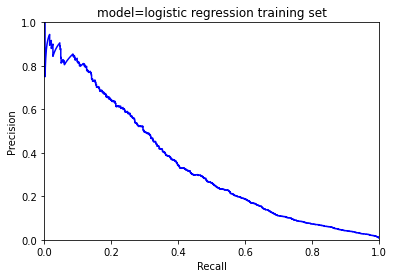

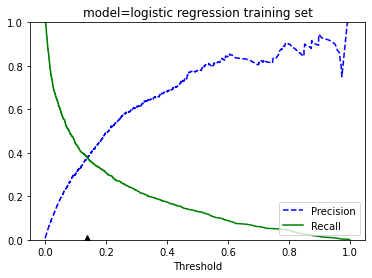

Confusion matrix for threshold = 0.14:
[[158954    635]
 [   636    386]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    159589
           1       0.38      0.38      0.38      1022

    accuracy                           0.99    160611
   macro avg       0.69      0.69      0.69    160611
weighted avg       0.99      0.99      0.99    160611



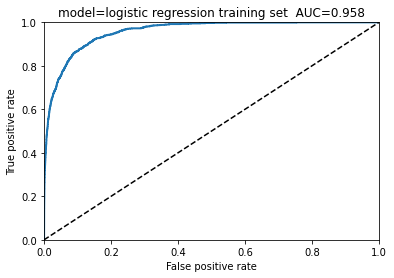

In [20]:
#performance on the training set
exec(open("my_functions.py").read())
probs_train = log_reg.predict_proba(X_train)
scores_train = probs_train[:, 1]
train_perf = get_model_performance('logistic regression training set', X_train, scores_train, y_train, pos_label=1)

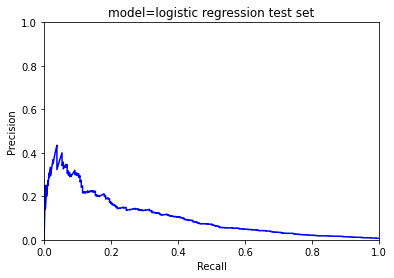

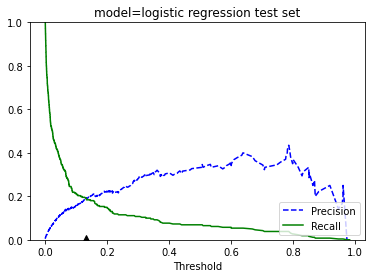

Confusion matrix for threshold = 0.13:
[[39682   210]
 [  211    50]]
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     39892
           1       0.19      0.19      0.19       261

    accuracy                           0.99     40153
   macro avg       0.59      0.59      0.59     40153
weighted avg       0.99      0.99      0.99     40153



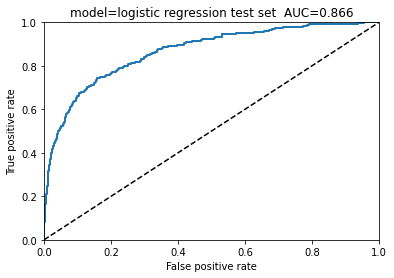

In [21]:
#performance on the test set
probs_test = log_reg.predict_proba(X_test)
scores_test = probs_test[:, 1]
test_perf = get_model_performance('logistic regression test set', X_test, scores_test, y_test, pos_label=1)